In [1]:
# Import required modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

In [2]:
## Read the input databases
trips = pd.read_csv("../../outputs/03_trips/bogota_trips_v00.csv", low_memory = False)
stages = pd.read_csv("../../data/08_MHS/EtapasEODH2019.csv", sep=';', decimal =',',low_memory=False)
persons = pd.read_csv("../../data/08_MHS/PersonasEODH2019.csv", sep=';', decimal = ',', low_memory=False)


In [3]:
## Split into the different groups
## Trips attached to BRT and Bus (Transmilenio and SITP, all trips, )
trips['travel_time'] = (trips['p31_hora_llegada']-trips['hora_inicio_viaje'])*(24*60)
trips_walking =trips[trips['modo_principal'] == 'A pie']
trips_transmilenio =trips[trips['modo_principal'] == 'TransMilenio'] 
trips_sitp = trips[trips['modo_principal'] == 'SITP Zonal']

## Trip purposes and aggregations
## Work:     Codes 1 and 2
## Study:    Code 3
## Shopping: Code 10
## Leisure:  Codes 5, 9, 12, 16
## Others:   All the remaining modes

walking_trips_work = trips_walking[(trips_walking['p17_Id_motivo_viaje'] == 1) | (trips_walking['p17_Id_motivo_viaje'] == 2)]
walking_trips_study = trips_walking[trips_walking['p17_Id_motivo_viaje'] == 3]
walking_trips_shopping = trips_walking[trips_walking['p17_Id_motivo_viaje'] == 10]
walking_trips_leisure = trips_walking[(trips_walking['p17_Id_motivo_viaje'] == 5) | (trips_walking['p17_Id_motivo_viaje'] == 9) | (trips_walking['p17_Id_motivo_viaje'] == 12) | (trips_walking['p17_Id_motivo_viaje'] == 16)]


In [4]:
## Calculation of walking time to BRT and Bus
## Stages to access to Transmilenio (discard ), only stage 1 (because 2 and 3 are not first legs)
#trips_transmilenio = trips_transmilenio[['id_hogar','id_persona','id_viaje','f_exp','modo_principal','travel_time']]
trips_transmilenio['id_hogar']=trips_transmilenio['id_hogar'].astype(str)
walking_access_TM = pd.merge(trips_transmilenio, stages, how='left', on=['id_hogar','id_persona','id_viaje'])
walking_access_TM = walking_access_TM[walking_access_TM['p18_id_medio_transporte']== 1]
walking_access_TM = walking_access_TM[walking_access_TM['id_etapa']== 1]
walking_access_TM

## BUS Only SITP = modes 04,05,06
#trips_sitp = trips_sitp[['id_hogar','id_persona','id_viaje','f_exp','modo_principal','travel_time']]
trips_sitp['id_hogar']=trips_sitp['id_hogar'].astype(str)
walking_access_sitp = pd.merge(trips_sitp, stages, how='left', on=['id_hogar','id_persona','id_viaje'] )
walking_access_sitp = walking_access_sitp[(walking_access_sitp['p18_id_medio_transporte'] >=4) & (walking_access_sitp['p18_id_medio_transporte'] <=6)]


walking_access_sitp = walking_access_sitp[walking_access_sitp['id_etapa']== 1]                                       
walking_access_sitp


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Unnamed: 0,id_hogar,id_persona,id_viaje,fecha,lugar_origen,zat_origen,p17_Id_motivo_viaje,p17_otro_motivo,hora_inicio_viaje,p28_lugar_destino,zat_destino,p29_id_municipio,p30_camino_cuadras,p30_camino_minutos,p31_hora_llegada,p32_lunes,p32_martes,p32_miercoles,p32_jueves,p32_viernes,p32_sabado,p32_domingo,p32_ocasional,p33_aplicacion_antes_viaje,p33_cual_aplicacion_antes_viaje,p34_aplicacion_durante_viaje,p34_cual_aplicacion_durante_viaje,p35_otro_desplazamiento,p36_hora_salida,f_exp_x,mun_origen,mun_destino,utam_origen,utam_destino,modo_principal,modo_principal_desagregado,Id_Hogar,Estado,p1_encuestador,p2_supervisor,p3_nro_mapa,p4_nro_manzana,Utam,Sector,Seccion,Manzana,p5_fecha,p7_Barrio_vivienda,Latitud,Longitud,zat_hogar,p8_hora_inicio_encuesta,p3_id_tipo_vivienda,p4_id_vivienda_propia,p5_estrato,p6_hogares_vivienda,p7_total_personas,p8_mayores_cinco_anios,id_rango_ingresos,colaboracion,p1mc_automovil,p1mc_camionetas,p1mc_pickup,p1mc_auto_servicio_especial,p1mc_motocicleta,p1mc_moto_carro,p1mc_triciclo_moto,p1mc_taxi,p1mc_camion,p1mc_bicitaxi,p1mc_bicitaxi_asistido,p1mc_bicitaxi_motor,P1mc_Patineta,p1mc_patineta_motor,p1mc_bicicleta_motor,p1mc_bicicleta_ninos,p1mc_bicicleta_sin_motor,p1mc_vehiculo_traccion_animal,p1mc_vehiculo_traccion_humana,p1mc_otro,p1mc_otros_cual,vivienda,Factor,municipio,localidad,travel_time,id_etapa,p18_id_medio_transporte,p18_medio_transporte_cual,p19_camino_cuadras,p19_camino_minutos,p20_Estacion_abordo_vehic,p21_tiempo_arrancar_vehic,p22_cuanto_pago,p23_modalidad_pago,p24_medio_pago,p25_lugar_descenso,p26a_propiedad_vehiculo,p26b_estacion_vehiculo,p26c_pago_estacionamiento,p26d_modalidad_pago,p26E_medio_pago_util,p27_experiencia_medio_transporte,f_exp_y
0,0,10001,1,1,43587.0,1.0,379.0,5,NaN,0.562500,2.0,947.0,11001.0,4.0,3.0,0.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,1.0,0.750000,208.504022,11001.0,11001.0,UTAM43,UTAM85,SITP Zonal,SITP - Urbano (Azul),10001,1,9825,NaN,1612,1.100114e+13,UTAM43,4307,2,5,2019-05-02,GALAN,4.6231333,-74.1178933,379,3:46:00 p. m.,2,3,3,4,2,2,2,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,16120085,208.504022,11001,PUENTE ARANDA,30.0,1,4,NaN,3.0,3.0,NaN,20.0,2200.0,1.0,2.0,BOSA SAN JOSE . ESPERANZA CAFAM VILLA JAVIER,NaN,NaN,NaN,NaN,NaN,1.0,208.504022272052
1,2,10001,2,1,43587.0,1.0,379.0,1,NaN,0.333333,2.0,334.0,11001.0,6.0,5.0,0.364583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,MOOVIT,1.0,MOOVIT,1.0,0.750000,208.504022,11001.0,11001.0,UTAM43,UTAM107,SITP Zonal,SITP - Urbano (Azul),10001,1,9825,NaN,1612,1.100114e+13,UTAM43,4307,2,5,2019-05-02,GALAN,4.6231333,-74.1178933,379,3:46:00 p. m.,2,3,3,4,2,2,2,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,16120085,208.504022,11001,PUENTE ARANDA,45.0,1,4,NaN,4.0,2.0,NaN,15.0,2200.0,1.0,2.0,CORFERIAS,NaN,NaN,NaN,NaN,NaN,3.0,208.504022272052
2,3,10001,2,2,43587.0,2.0,334.0,6,NaN,0.750000,1.0,379.0,11001.0,2.0,1.0,0.791667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,2.0,NaN,208.504022,11001.0,11001.0,UTAM107,UTAM43,SITP Zonal,SITP - Urbano (Azul),10001,1,9825,NaN,1612,1.100114e+13,UTAM43,4307,2,5,2019-05-02,GALAN,4.6231333,-74.1178933,379,3:46:00 p. m.,2,3,3,4,2,2,2,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,16120085,208.504022,11001,PUENTE ARANDA,60.0,1,4,NaN,6.0,5.0,NaN,25.0,2200.0,1.0,2.0,KR 56 CL 3,NaN,NaN,NaN,NaN,NaN,3.0,208.504022272052
3,5,10003,1,1,43586.0,1.0,1036.0,10,NaN,0.375000,2.0,26.0,11001.0,3.0,10.0,0.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,1.0,0.541667,36.267857,11001.0,11001.0,UTAM2,UTAM10,SITP Zonal,SITP - Urbano (Azul),10003,2,9068,NaN,950,1.100119e+13,UTAM2,9124,1,17,2019-05-01,EL JARDIN,4.79786,-74.0445467,1036,12:26:00 p. m.,1,1,6,1,3,3,1,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,9500004,36.267857,11001,SUBA,60.0,1,4,NaN,4.0,10.0,NaN,15.0,2300.0,1.0,2.0,Estación toberin,NaN,NaN,NaN,NaN,NaN,4.0,36.2678569534785
4,6,10003,1,2,43586.0,2.0,26.0,6,NaN,0.541667,1.0,1036.0,11001.0,4.0,10.0,0.562500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,2.0,NaN,2.0,NaN,36.267857,11001.0,

In [5]:
### Extra processing 
persons
persons_reduced= persons[['id_hogar','id_persona','p4_edad','p6_id_ocupacion','p6_id_ocupacion_O1','p6_id_ocupacion_O2','p6_id_ocupacion_O3']]


In [6]:
## Subsegmentation of full-walking study trips

walking_trips_study['id_hogar']=walking_trips_study['id_hogar'].astype(str)
walking_trips_study['id_persona']=walking_trips_study['id_persona'].astype(str)
persons_reduced['id_hogar']=persons_reduced['id_hogar'].astype(str)
persons_reduced['id_persona']=persons_reduced['id_persona'].astype(str)

walking_trips_study_merge = pd.merge(walking_trips_study, persons_reduced, how='left', on=['id_hogar','id_persona'])

## Subgroup 1: Kindergarden
walking_trips_kindergarten = walking_trips_study_merge[(walking_trips_study_merge['p6_id_ocupacion'] == 35) |(walking_trips_study_merge['p6_id_ocupacion_O1'] == 35)|(walking_trips_study_merge['p6_id_ocupacion_O2'] == 35)|(walking_trips_study_merge['p6_id_ocupacion_O3'] == 35)]

## Subgroup 2: School trips
walking_trips_school = walking_trips_study_merge[walking_trips_study_merge['p6_id_ocupacion'] == 1]

## Subgroup 3: University
walking_trips_university = walking_trips_study_merge[(walking_trips_study_merge['p6_id_ocupacion'] <=4) & (walking_trips_study_merge['p6_id_ocupacion'] >=2) ]

walking_trips_university.describe()
#walking_trips_study_merge




C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Unnamed: 0,id_viaje,fecha,lugar_origen,zat_origen,p17_Id_motivo_viaje,hora_inicio_viaje,p28_lugar_destino,zat_destino,p29_id_municipio,p30_camino_cuadras,p30_camino_minutos,p31_hora_llegada,p32_lunes,p32_martes,p32_miercoles,p32_jueves,p32_viernes,p32_sabado,p32_domingo,p32_ocasional,p33_aplicacion_antes_viaje,p34_aplicacion_durante_viaje,p35_otro_desplazamiento,p36_hora_salida,f_exp,mun_origen,mun_destino,Estado,p1_encuestador,p2_supervisor,p3_nro_mapa,p4_nro_manzana,Sector,Seccion,Manzana,zat_hogar,p3_id_tipo_vivienda,p4_id_vivienda_propia,p5_estrato,p6_hogares_vivienda,p7_total_personas,p8_mayores_cinco_anios,id_rango_ingresos,colaboracion,p1mc_automovil,p1mc_camionetas,p1mc_pickup,p1mc_auto_servicio_especial,p1mc_motocicleta,p1mc_moto_carro,p1mc_triciclo_moto,p1mc_taxi,p1mc_camion,p1mc_bicitaxi,p1mc_bicitaxi_asistido,p1mc_bicitaxi_motor,P1mc_Patineta,p1mc_patineta_motor,p1mc_bicicleta_motor,p1mc_bicicleta_ninos,p1mc_bicicleta_sin_motor,p1mc_vehiculo_traccion_animal,p1mc_vehiculo_traccion_humana,p1mc_otro,vivienda,Factor,municipio,travel_time,p4_edad,p6_id_ocupacion,p6_id_ocupacion_O1,p6_id_ocupacion_O2,p6_id_ocupacion_O3
count,284.000000,284.000000,247.000000,247.000000,247.000000,284.0,284.000000,247.0,247.000000,247.0,247.000000,247.000000,284.000000,195.0,198.0,212.0,202.0,159.0,25.0,1.0,22.0,247.000000,247.000000,247.000000,280.000000,284.000000,247.000000,247.0,284.000000,284.000000,0.0,284.000000,2.840000e+02,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,200.000000,284.000000,284.000000,284.000000,284.0,284.000000,284.0,284.0,284.000000,284.000000,284.000000,284.0,284.0,284.000000,284.0,284.000000,284.000000,284.000000,284.0,284.000000,284.000000,2.840000e+02,284.000000,284.0,284.000000,284.000000,284.000000,82.000000,6.000000,0.0
mean,71999.866197,1.503521,43590.894737,1.222672,358.489879,3.0,0.414175,2.0,362.595142,11001.0,9.117409,15.805668,0.427575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.975709,1.991903,1.012146,0.646386,95.574876,10956.461538,11001.0,1.186620,6776.721831,NaN,1912.316901,1.100115e+13,5351.806338,2.345070,11.070423,377.482394,1.739437,2.309859,3.091549,1.447183,3.214789,3.169014,4.183099,1.470000,0.260563,0.080986,0.010563,0.0,0.123239,0.0,0.0,0.010563,0.014085,0.014085,0.0,0.0,0.028169,0.0,0.007042,0.123239,0.658451,0.0,0.010563,0.003521,1.912327e+07,95.574876,11001.0,19.295775,22.183099,2.394366,22.670732,24.666667,NaN
std,37226.007202,0.964010,38.448004,0.416885,165.489588,0.0,0.160312,0.0,169.802223,0.0,7.605517,10.899517,0.161069,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.154265,0.089801,0.109759,0.148638,97.835262,699.976868,0.0,0.390294,4098.039864,NaN,1201.239097,2.515360e+07,2515.360433,2.031712,10.223404,192.554475,0.547136,1.141465,0.920170,1.424431,2.022749,1.978584,2.732140,0.500352,0.520662,0.285932,0.102414,0.0,0.350097,0.0,0.0,0.102414,0.237356,0.144922,0.0,0.0,0.185848,0.0,0.083770,0.439590,0.983737,0.0,0.102414,0.059339,1.201240e+07,97.835262,0.0,17.592678,6.432163,0.737274,12.187886,9.831921,NaN
min,254.000000,1.000000,43519.000000,1.000000,33.000000,3.0,0.152778,2.0,22.000000,11001.0,1.000000,1.000000,0.218750,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.243056,1.000000,0.000000,11001.0,1.000000,30.000000,NaN,15.000000,1.100111e+13,1101.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.500020e+05,1.000000,11001.0,1.000000,12.000000,2.000000,3.000000,16.000000,NaN
25%,36609.000000,1.000000,43560.000000,1.000000,275.000000,3.0,0.277778,2.0,271.000000,11001.0,4.000000,10.000000,0.291667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,2.000000,1.000000,0.541667,40.675041,11001.000000,11001.0,1.000000,537.500000,NaN,838.750000,1.100113e+13,3103.000000,1.000000,5.000000,272.000000,1.000000,1.000000,3.000000,1.000000

In [7]:
#General description of all travel times (just activate one)

#walking_trips_work.describe()
walking_trips_kindergarten.describe()
#walking_trips_school.describe()
#walking_trips_university.describe()
#walking_trips_shopping.describe()
#walking_trips_leisure.describe()
#walking_access_TM.describe() 
#walking_access_sitp.describe()


,Unnamed: 0,id_viaje,fecha,lugar_origen,zat_origen,p17_Id_motivo_viaje,hora_inicio_viaje,p28_lugar_destino,zat_destino,p29_id_municipio,p30_camino_cuadras,p30_camino_minutos,p31_hora_llegada,p32_lunes,p32_martes,p32_miercoles,p32_jueves,p32_viernes,p32_sabado,p32_domingo,p32_ocasional,p33_aplicacion_antes_viaje,p34_aplicacion_durante_viaje,p35_otro_desplazamiento,p36_hora_salida,f_exp,mun_origen,mun_destino,Estado,p1_encuestador,p2_supervisor,p3_nro_mapa,p4_nro_manzana,Sector,Seccion,Manzana,zat_hogar,p3_id_tipo_vivienda,p4_id_vivienda_propia,p5_estrato,p6_hogares_vivienda,p7_total_personas,p8_mayores_cinco_anios,id_rango_ingresos,colaboracion,p1mc_automovil,p1mc_camionetas,p1mc_pickup,p1mc_auto_servicio_especial,p1mc_motocicleta,p1mc_moto_carro,p1mc_triciclo_moto,p1mc_taxi,p1mc_camion,p1mc_bicitaxi,p1mc_bicitaxi_asistido,p1mc_bicitaxi_motor,P1mc_Patineta,p1mc_patineta_motor,p1mc_bicicleta_motor,p1mc_bicicleta_ninos,p1mc_bicicleta_sin_motor,p1mc_vehiculo_traccion_animal,p1mc_vehiculo_traccion_humana,p1mc_otro,vivienda,Factor,municipio,travel_time,p4_edad,p6_id_ocupacion,p6_id_ocupacion_O1,p6_id_ocupacion_O2,p6_id_ocupacion_O3
count,14.000000,14.0,14.000000,14.000000,14.000000,14.0,14.000000,14.0,14.000000,14.0,14.000000,14.000000,14.000000,14.0,14.0,14.0,14.0,14.0,0.0,0.0,0.0,14.0,14.0,14.0,14.000000,14.000000,14.0,14.0,14.000000,14.000000,0.0,14.000000,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,9.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.000000,14.0,14.0,14.000000,14.000000,14.0,14.0,14.0,1.400000e+01,14.000000,14.0,14.000000,14.000000,14.000000,5.000000,0.0,0.0
mean,78019.714286,1.0,43609.071429,1.071429,445.928571,3.0,0.311756,2.0,382.714286,11001.0,7.214286,15.357143,0.327133,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,2.0,1.0,0.629960,169.872246,11001.0,11001.0,1.214286,6051.857143,NaN,1413.571429,1.100115e+13,5317.357143,2.857143,13.071429,449.714286,1.571429,2.285714,3.000000,1.357143,3.642857,3.500000,4.500000,1.444444,0.285714,0.071429,0.071429,0.0,0.214286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.928571,0.928571,0.0,0.0,0.0,1.413576e+07,169.872246,11001.0,22.142857,5.142857,27.714286,36.200000,NaN,NaN
std,38283.497836,0.0,46.476569,0.267261,263.567964,0.0,0.066639,0.0,262.246340,0.0,5.604649,12.743669,0.065612,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.096904,153.229413,0.0,0.0,0.425815,4551.418170,NaN,979.170270,2.389850e+07,2389.855020,2.597547,10.432673,266.638744,0.513553,0.994490,1.358732,0.841897,1.336306,1.344504,3.057148,0.527046,0.468807,0.267261,0.267261,0.0,0.425815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851631,0.0,0.0,0.730046,0.916875,0.0,0.0,0.0,9.791719e+06,153.229413,0.0,21.346436,0.534522,14.477721,1.643168,NaN,NaN
min,13592.000000,1.0,43533.000000,1.000000,13.000000,3.0,0.250000,2.0,11.000000,11001.0,1.000000,2.000000,0.260417,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,2.0,1.0,0.416667,28.632519,11001.0,11001.0,1.000000,250.000000,NaN,78.000000,1.100111e+13,1401.000000,1.000000,2.000000,13.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,7.800050e+05,28.632519,11001.0,2.000000,5.000000,1.000000,35.000000,NaN,NaN
25%,50925.500000,1.0,43572.750000,1.000000,283.500000,3.0,0.278646,2.0,219.500000,11001.0,3.250000,5.000000,0.291667,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,2.0,1.0,0.567708,74.616112,11001.0,11001.0,1.000000,619.250000,NaN,445.000000,1.100113e+13,3038.000000,1.000000,4.000000,283.500000,1.000000,1.000000,2.000000,1.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.000000,0.0,0.0,0.0,4.450043e+06,74.616112,11001.0,6.250000,5.000000,35.000000,35.000000,NaN,NaN
50%,72507.500000,1.0,43609.000000,1.000000,393.000000,3.0,0.298611,2.0,337.500000,11001.0,5.50000

In [8]:
## Process for sample analysis, (filter only travel time >= 0)
## This process is not performed for the gravity model, is the input of sample distribution

w_trips_work_sample = walking_trips_work[walking_trips_work['travel_time'] >= 0]
w_trips_work_sample['travel_type'] = 'work'
w_trips_work_sample = w_trips_work_sample[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]


w_trips_kindergarte = walking_trips_kindergarten[walking_trips_kindergarten['travel_time'] >= 0]
w_trips_kindergarte['travel_type'] = 'study-kinder'
w_trips_kindergarte = w_trips_kindergarte[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

w_trips_school = walking_trips_school[walking_trips_school['travel_time'] >= 0]
w_trips_school['travel_type'] = 'study-school'
w_trips_school = w_trips_school[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

w_trips_university = walking_trips_university[walking_trips_university['travel_time'] >= 0]
w_trips_university['travel_type'] = 'study-university'
w_trips_university = w_trips_university[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

w_trips_shopping = walking_trips_shopping[walking_trips_shopping['travel_time'] >= 0]
w_trips_shopping['travel_type'] = 'shopping'
w_trips_shopping = w_trips_shopping[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]


w_trips_leisure = walking_trips_leisure[walking_trips_leisure['travel_time'] >= 0]
w_trips_leisure['travel_type'] = 'leisure'
w_trips_leisure = w_trips_leisure[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

w_access_TM = walking_access_TM[walking_access_TM['p19_camino_minutos'] >= 0]
w_access_TM['travel_type'] = 'walking_tm'
w_access_TM['travel_time'] = w_access_TM['p19_camino_minutos']
w_access_TM['f_exp'] = w_access_TM['Factor'] 

w_access_TM = w_access_TM[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

w_access_sitp = walking_access_sitp[walking_access_sitp['p19_camino_minutos'] >= 0]
w_access_sitp['travel_type'] = 'walking_sitp'
w_access_sitp['travel_time'] = w_access_sitp['p19_camino_minutos']
w_access_sitp['f_exp'] = w_access_sitp['Factor']
w_access_sitp = w_access_sitp[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]


## Append database

append_db = w_trips_work_sample.append(w_trips_kindergarte)
append_db = append_db.append(w_trips_school)
append_db = append_db.append(w_trips_university)
append_db = append_db.append(w_trips_shopping)
append_db = append_db.append(w_trips_leisure)
append_db = append_db.append(w_access_TM)
append_db = append_db.append(w_access_sitp)

append_db.to_csv('../../outputs/03_trips/trips_dataset_to_unit_testing.csv')
append_db





C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,id_hogar,id_persona,id_viaje,zat_origen,zat_destino,f_exp,utam_origen,utam_destino,modo_principal_desagregado,Utam,Sector,Seccion,Manzana,Latitud,Longitud,p5_estrato,localidad,travel_time,travel_type
71,10025,1,1,438.0,444.0,49.184386,UTAM37,UTAM102,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.5994196,-74.0951576,3,LOS MARTIRES,10.0,work
74,10026,1,3,439.0,993.0,49.184386,UTAM37,UTAM93,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.599457,-74.0954243,3,LOS MARTIRES,30.0,work
76,10026,1,1,438.0,993.0,49.184386,UTAM37,UTAM93,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.599457,-74.0954243,3,LOS MARTIRES,15.0,work
117,10036,1,1,305.0,305.0,27.227772,UTAM115,UTAM115,A pie (Viajes totalmente a pie),UTAM115,6403,2,12,4.682895,-74.1343917,3,FONTIBON,15.0,work
120,10036,3,1,305.0,314.0,27.227772,UTAM115,UTAM75,A pie (Viajes totalmente a pie),UTAM115,6403,2,12,4.682895,-74.1343917,3,FONTIBON,10.0,work
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11593,P08677,1,2,55.0,208.0,72.206508,UTAM10,UTAM26,SITP - Urbano (Azul),UTAM11,8535,3,11,4.73487600917,-74.0152696015,1,USAQUEN,3.0,walking_sitp
11594,P08678,1,1,58.0,254.0,72.206508,UTAM11,UTAM97,SITP - Urbano (Azul),UTAM11,8535,3,11,4.73487600917,-74.0152696015,1,USAQUEN,30.0,walking_sitp
11595,P08678,1,2,254.0,58.0,72.206508,UTAM97,UTAM11,SITP - Urbano (Azul),UTAM11,8535,3,11,4.73487600917,-74.0152696015,1,USAQUEN,5.0,walking_sitp
11597,P08708,1,2,271.0,150.0,32.184033,UTAM99,UTAM14,SITP - Urbano (Azul),UTAM14,8411,2,6,4.68606553814,-74.0447909883,6,USAQUEN,2.0,walking_sitp


In [9]:
#w_trips_work_sample
w_trips_work_sample[['id_hogar','id_persona','id_viaje','zat_origen','zat_destino','f_exp','utam_origen','utam_destino','modo_principal_desagregado','Utam','Sector','Seccion','Manzana','Latitud','Longitud','p5_estrato','localidad','travel_time','travel_type']]

,id_hogar,id_persona,id_viaje,zat_origen,zat_destino,f_exp,utam_origen,utam_destino,modo_principal_desagregado,Utam,Sector,Seccion,Manzana,Latitud,Longitud,p5_estrato,localidad,travel_time,travel_type
71,10025,1,1,438.0,444.0,49.184386,UTAM37,UTAM102,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.5994196,-74.0951576,3,LOS MARTIRES,10.0,work
74,10026,1,3,439.0,993.0,49.184386,UTAM37,UTAM93,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.599457,-74.0954243,3,LOS MARTIRES,30.0,work
76,10026,1,1,438.0,993.0,49.184386,UTAM37,UTAM93,A pie (Viajes totalmente a pie),UTAM37,4106,3,1,4.599457,-74.0954243,3,LOS MARTIRES,15.0,work
117,10036,1,1,305.0,305.0,27.227772,UTAM115,UTAM115,A pie (Viajes totalmente a pie),UTAM115,6403,2,12,4.682895,-74.1343917,3,FONTIBON,15.0,work
120,10036,3,1,305.0,314.0,27.227772,UTAM115,UTAM75,A pie (Viajes totalmente a pie),UTAM115,6403,2,12,4.682895,-74.1343917,3,FONTIBON,10.0,work
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106169,P08628,3,3,342.0,344.0,40.331493,UTAM91,UTAM101,A pie (Viajes totalmente a pie),UTAM38,2107,3,3,4.5971419312,-74.107622192,3,ANTONIO NARINO,5.0,work
106199,P08648,1,1,11.0,11.0,198.199057,UTAM9,UTAM9,A pie (Viajes totalmente a pie),UTAM9,8526,1,6,4.76412182479,-74.0380889119,3,USAQUEN,5.0,work
106261,P08656,1,3,69.0,442.0,51.790016,UTAM13,UTAM102,A pie (Viajes totalmente a pie),UTAM15,8401,1,43,4.71615481765,-74.047823483,5,USAQUEN,4.0,work
106262,P08656,1,1,88.0,76.0,51.790016,UTAM15,UTAM13,A pie (Viajes totalmente a pie),UTAM15,8401,1,43,4.71615481765,-74.047823483,5,USAQUEN,5.0,work


In [10]:
## Data refinement (only trips between 0 to 30 mins) (At least 75% in all the cases)
walking_trips_work = walking_trips_work[(walking_trips_work['travel_time'] <= 30) & (walking_trips_work['travel_time'] >= 0)]

walking_trips_kindergarten = walking_trips_kindergarten[(walking_trips_kindergarten['travel_time'] <= 30) & (walking_trips_kindergarten['travel_time'] >= 0)]
walking_trips_school = walking_trips_school[(walking_trips_school['travel_time'] <= 30) & (walking_trips_school['travel_time'] >= 0)]
walking_trips_university = walking_trips_university[(walking_trips_university['travel_time'] <= 30) & (walking_trips_university['travel_time'] >= 0)]

walking_trips_shopping = walking_trips_shopping[(walking_trips_shopping['travel_time'] <= 30) & (walking_trips_shopping['travel_time'] >= 0)]
walking_trips_leisure = walking_trips_leisure[(walking_trips_leisure['travel_time'] <= 30) & (walking_trips_leisure['travel_time'] >= 0)]

walking_access_TM = walking_access_TM[(walking_access_TM['p19_camino_minutos'] <= 30) & (walking_access_TM['p19_camino_minutos'] >= 0)]
walking_access_sitp = walking_access_sitp[(walking_access_sitp['p19_camino_minutos'] <= 30) & (walking_access_sitp['p19_camino_minutos'] >= 0)]


In [11]:
## Impedance functions definitions

## 01. Inverse power
def func_inversep(x, alpha):
    return(x**(-alpha))

## 02. Neg. Exponential
def function_exponential(x, beta):
    return(np.exp(-beta*x))

## 03. Modified gaussian (GOAT)
def func_goat(x, beta):
    return (np.exp(-((x)**2)/beta))

## 04. S-Shape (Inverse sigmoid logit)
def func_shape(x,b,c):
    return(1/(1+(b*c*np.exp(x))))

01 Inverse power function
R^2, = 0.6513456816151887
Alpha =  [0.34721817]
02 Negative exponential
R^2, = 0.9298776153120006
Beta =  [0.06175892]
03 Modified Gaussian (GOAT)
R^2, = 0.957689297275373
Beta =  [254.07580501]
04 S-shape function
R^2, = 0.5746977861007593
B =  -0.007485139347059565 C =  -0.0005019475786824441


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


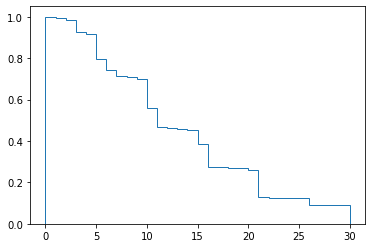

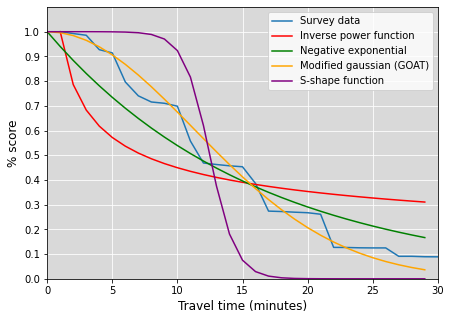

In [12]:
## Model 01: Walking trips to work

n2, bins2, patches = plt.hist(walking_trips_work['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()



01 Inverse power function
R^2, = 0.7157924956948419
Alpha =  [0.36726894]
02 Negative exponential
R^2, = 0.8889300679776676
Beta =  [0.06582223]
03 Modified Gaussian (GOAT)
R^2, = 0.6839005271556025
Beta =  [219.59835064]
04 S-shape function
R^2, = 0.1610903284880396
B =  -0.0021814827418071498 C =  -0.003450055065464218


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


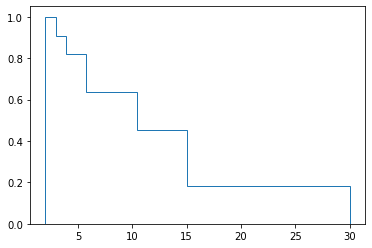

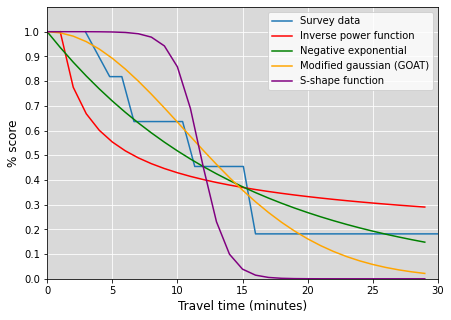

In [13]:
## Model 02: Walking trips to kindergarten

n2, bins2, patches = plt.hist(walking_trips_kindergarten['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

01 Inverse power function
R^2, = 0.6026521488754757
Alpha =  [0.33944566]
02 Negative exponential
R^2, = 0.8968591653110215
Beta =  [0.06039828]
03 Modified Gaussian (GOAT)
R^2, = 0.9749483888361593
Beta =  [262.20785547]
04 S-shape function
R^2, = 0.6777091528749531
B =  0.0026546914705051932 C =  0.0007525159929815061


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


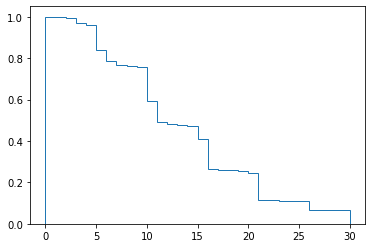

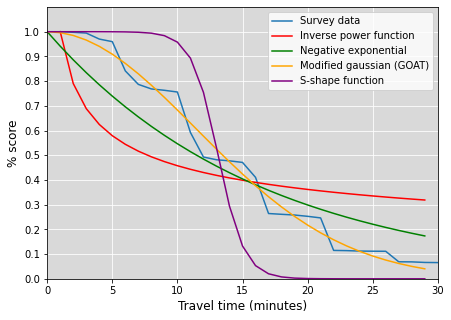

In [14]:
## Model 03: Walking trips to school (primary, secondary)

n2, bins2, patches = plt.hist(walking_trips_school['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

01 Inverse power function
R^2, = 0.6015140957428653
Alpha =  [0.3226647]
02 Negative exponential
R^2, = 0.892507469272379
Beta =  [0.05726121]
03 Modified Gaussian (GOAT)
R^2, = 0.9546851097151666
Beta =  [283.31484512]
04 S-shape function
R^2, = 0.6197602749574371
B =  0.0023331135590551515 C =  0.00032444965324259


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


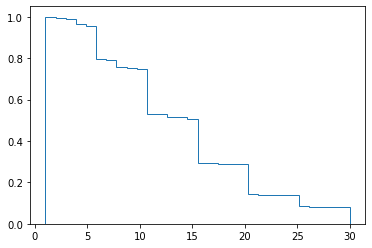

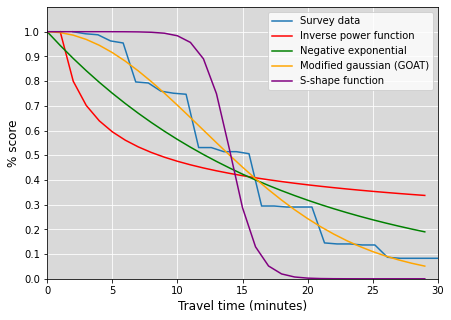

In [15]:
## Model 04: Walking trips to university (bachelor, technical and post-graduate)

n2, bins2, patches = plt.hist(walking_trips_university['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

01 Inverse power function
R^2, = 0.6610230295945162
Alpha =  [0.38276561]
02 Negative exponential
R^2, = 0.9152760098468752
Beta =  [0.06954724]
03 Modified Gaussian (GOAT)
R^2, = 0.9290747401937985
Beta =  [205.90206249]
04 S-shape function
R^2, = 0.6410793501516634
B =  -0.006696345369762905 C =  -0.0015838492694584024


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


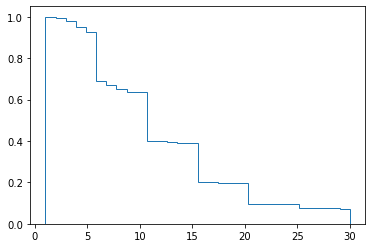

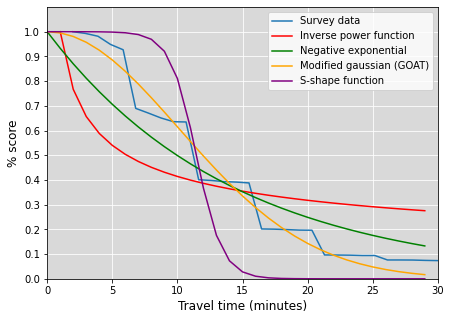

In [16]:
## Model 05: Walking trips to shopping

n2, bins2, patches = plt.hist(walking_trips_shopping['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

In [17]:
#pcov1
#pcov2
#pcov3
pcov4
yData

array([1.        , 0.99312321, 0.98166189, 0.94842407, 0.9269341 ,
       0.68968481, 0.67077364, 0.65100287, 0.63581662, 0.63467049,
       0.4008596 , 0.39799427, 0.39340974, 0.39140401, 0.38796562,
       0.2017192 , 0.2008596 , 0.1991404 , 0.19713467, 0.1965616 ,
       0.0965616 , 0.09627507, 0.09570201, 0.09426934, 0.09426934,
       0.07621777, 0.07621777, 0.07593123, 0.07449857, 0.07363897])

01 Inverse power function
R^2, = 0.657950201816341
Alpha =  [0.34941971]
02 Negative exponential
R^2, = 0.9299666164469875
Beta =  [0.0623788]
03 Modified Gaussian (GOAT)
R^2, = 0.9526119369735387
Beta =  [247.20435214]
04 S-shape function
R^2, = 0.5832652527897906
B =  0.005392416214139477 C =  0.0008834367844875738


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


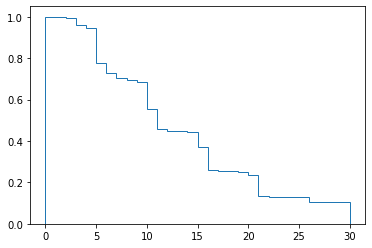

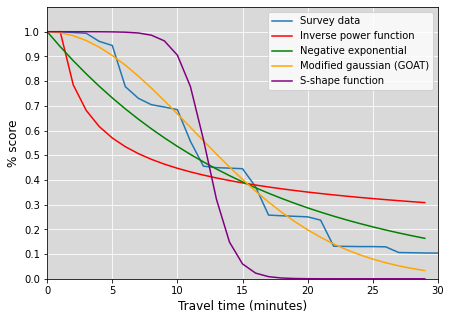

In [18]:
## Model 06: Walking trips for leisure

n2, bins2, patches = plt.hist(walking_trips_leisure['travel_time'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

01 Inverse power function
R^2, = 0.6477279739262928
Alpha =  [0.45573735]
02 Negative exponential
R^2, = 0.9097269019216921
Beta =  [0.08480702]
03 Modified Gaussian (GOAT)
R^2, = 0.9727406998143349
Beta =  [149.15307772]
04 S-shape function
R^2, = 0.8151745340476981
B =  -0.019004279010127228 C =  -0.0018572264810826269


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


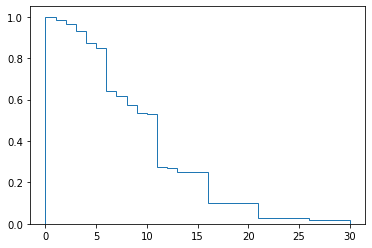

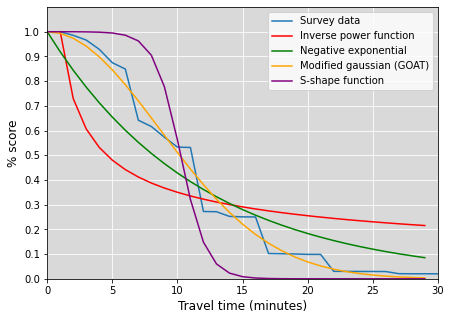

In [19]:
## Model 07: Walking stages to access to TM

n2, bins2, patches = plt.hist(walking_access_TM['p19_camino_minutos'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()

01 Inverse power function
R^2, = 0.7160779463069935
Alpha =  [0.52950125]
02 Negative exponential
R^2, = 0.9379497548853781
Beta =  [0.10239052]
03 Modified Gaussian (GOAT)
R^2, = 0.9596046081378895
Beta =  [103.68434517]
04 S-shape function
R^2, = 0.8185417669414107
B =  -0.03194124834438424 C =  -0.010435647565411557


C:\Users\rafle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


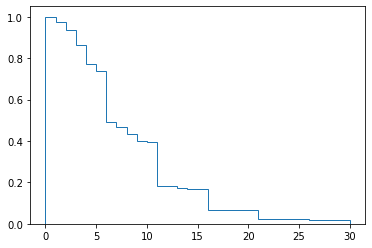

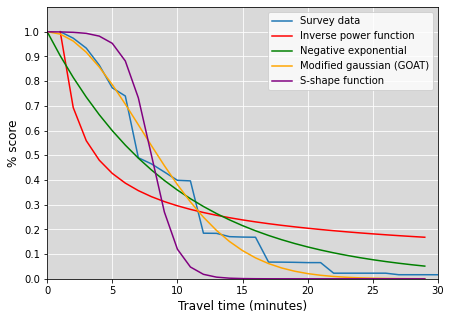

In [20]:
## Model 08: Walking stages to access to sitp

n2, bins2, patches = plt.hist(walking_access_sitp['p19_camino_minutos'], (30), density=True, histtype='step',
                           cumulative= -1)

plt.figure(figsize=(7,5))
ax = plt.axes()
plt.xticks(np.arange(0,31,step=5), fontsize =10)
plt.yticks(np.arange(0,1.1, step = 0.1), fontsize =10)
plt.grid(color='white')

xData = np.array(bins2[1:])
yData = np.array(n2)
plt.plot(xData, yData, label = "Survey data")
plt.xlim([0,30])
plt.ylim([0,1.1])

##Fit 01, inverse
popt1, pcov1 = curve_fit(func_inversep, xData, yData, method='lm')
xFit = np.arange(0, 30, 1)
print ('01 Inverse power function')
print ('R^2, =',r2_score(yData[1:], func_inversep(xFit[1:],*popt1)))
print ('Alpha = ', popt1)

plt.plot(xFit, func_inversep(xFit,*popt1), 'r', label='Inverse power function')

##Fit 02, neg, exponential
popt2, pcov2 = curve_fit(function_exponential, xData, yData)
plt.plot(xFit, function_exponential(xFit,*popt2), 'g',label='Negative exponential')

print ('02 Negative exponential')
print ('R^2, =',r2_score(yData, function_exponential(xFit,*popt2)))
print ('Beta = ', popt2)

##Fit 03, Modified gaussian
popt3, pcov3 = curve_fit(func_goat, xData, yData)
plt.plot(xFit, func_goat(xFit,*popt3), 'orange', label='Modified gaussian (GOAT)')

print ('03 Modified Gaussian (GOAT)')
print ('R^2, =',r2_score(yData, func_goat(xFit,*popt3)))
print ('Beta = ', popt3)

##Fit 04, S-shape
popt4, pcov4 = curve_fit(func_shape, xData, yData)
plt.plot(xFit, func_shape(xFit,*popt4), 'purple',label='S-shape function')

print ('04 S-shape function')
print ('R^2, =',r2_score(yData, func_shape(xFit,*popt4)))
print ('B = ', popt4[0], 'C = ', popt4[1])

## Graphic details

plt.xlabel("Travel time (minutes)", fontsize=12)
plt.ylabel("% score", fontsize=12)
ax.set_facecolor("#d9d9d9")
plt.legend()
plt.show()